In [1]:
from skimage import io
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
import numpy as np
from math import *
from skimage.draw import circle
import os
import shutil

#imports for widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
#functions
def normalize(tab):
    myMax = np.max(tab)
    myMin=np.min(tab)
    newMax=1
    newMin=0
    for i in range(0, tab.shape[0]):
        for k in range(0, tab.shape[1]):
            tab[i][k] = (((tab[i][k] - myMin) / (myMax - myMin)) * (newMax - newMin)) + newMin
    return tab

def createMask(ndetektorow):
    ndetektorow = int(ndetektorow // 18) #wielkosc maski = dlugosc wiersza / 18
    if(ndetektorow % 2 == 0):
        ndetektorow += 1
    mask = np.zeros((ndetektorow))
    iterator = 0
    for h in range(int(len(mask)/2), len(mask), 1):
        if(iterator % 2 != 0):
            mask[h] = -4 / (pi * pi * iterator * iterator)
        else:
            mask[h] = 0
        iterator += 1
    for h in range(0, int(len(mask) / 2)):
        y = ((-1 * h) + len(mask)) -1
        mask[h] =  mask[y]
    srodek = int(len(mask) / 2)
    mask[srodek] = 1
    return mask

def calculateMeanSquaredError(tabA, tabB):
    return np.power(np.subtract(tabA, tabB), 2).mean() ** 0.5

def calculateAvg(myLine, image):
    sum = 0
    for y, x in myLine:
        sum += image[y,x]
    return sum / len(myLine)

def line(x0,y0, x1,y1):
    myLine = []
    dx = x1-x0
    dy = y1-y0

    def sign(x):
        if x >= 0: return +1
        else: return -1

    inc_x = sign(dx)
    inc_y = sign(dy)
    dx = abs(dx)
    dy = abs(dy)
    if dx >= dy:
        d = 2 * dy - dx
        delta_A = 2 * dy
        delta_B = 2 * dy - 2 * dx
        x, y = (0, 0)
        for i in range(dx+1):
            myLine.append([y0 + y, x0 + x])
            if d > 0:
                d += delta_B
                x += inc_x
                y += inc_y
            else:
                d += delta_A
                x += inc_x
    else:
        d = 2 * dx - dy
        delta_A = 2 * dx
        delta_B = 2 * dx - 2 * dy
        x, y = (0, 0)
        for i in range(dy+1):
            myLine.append([y0 + y, x0 + x])
            if d > 0:
                d += delta_B
                x += inc_x
                y += inc_y
            else:
                d += delta_A
                y += inc_y
    return myLine

def myConvolve(tab, mask):
    out_sinogram = np.zeros_like(tab)
    base_sinogram = tab
    myFilter = mask
    half_filtr_len = len(myFilter) // 2
    padding = 2 * half_filtr_len + 1
    pad_array = np.zeros(half_filtr_len)
    for ind_x, x in enumerate(base_sinogram):
        for i in range(base_sinogram.shape[1]):
            out_sinogram[ind_x][i] = np.sum(np.concatenate([pad_array, x, pad_array])[i:i + padding] * myFilter)
    return out_sinogram

def cutCircle(image):
    img = np.zeros_like(image)
    h, w = image.shape
    r = min(h, w) / 2 - 1
    center = h / 2, w / 2
    rr, cc = circle(center[0], center[1], r)
    img[rr, cc] = 1
    return img

In [3]:
#main
def main(krok = 360, ndetektorow = 300, rozpietosc = 270, useMask = True, fileName = "Kwadraty2.jpg"):
    #fileName = "Kwadraty2.jpg"
    catalogName = "photos"
    shutil.rmtree(os.getcwd() + '/' + catalogName)
    os.makedirs(catalogName)
    image = io.imread("tomograf-zdjecia/" + fileName, as_grey=True)
    h, w = image.shape # wysokosc, szerokosc
    r = min(h, w) / 2 - 1 # aby sie odsunac od krawedzi
    center = h / 2, w / 2
    #krok = 360
    #ndetektorow = 300
    #rozpietosc = 270 # phi
    alfa = 360 / krok
    sinogram = np.zeros((krok, ndetektorow))
    retrieveImage = np.zeros((h, w))

    #create sinogram
    for i in range(0, krok):
        xe = int(round(r * cos(radians(alfa * i)) + center[1], 1))
        ye = int(round(r * sin(radians(alfa * i)) + center[0], 1))
        for k in range(0, ndetektorow):
            xdi = int(round(r * cos(radians(alfa * i + 180 - rozpietosc / 2 + k * rozpietosc / (ndetektorow - 1))), 1) + center[1])
            ydi = int(round(r * sin(radians(alfa * i + 180 - rozpietosc / 2 + k * rozpietosc / (ndetektorow - 1))), 1) + center[0])
            sinogram[i][k] = calculateAvg(line(xe, ye, xdi, ydi), image)
    
    if (useMask):
        #create mask
        mask = createMask(ndetektorow)
        #create sinogram with mask
        sinogramAfterConv = myConvolve(sinogram, mask)
    else:
        sinogramAfterConv = sinogram
    print("Sinogram:")
    io.imshow(sinogramAfterConv)
    plt.show()
    #retrieve image from sinogram
    for i in range(0, krok):
        xe = int(round(r * cos(radians(alfa * i)) + center[1], 1))
        ye = int(round(r * sin(radians(alfa * i)) + center[0], 1))
        for k in range(0, ndetektorow):
            xdi = int(round(r * cos(radians(alfa * i + 180 - rozpietosc / 2 + k * rozpietosc / (ndetektorow - 1))), 1) + center[1])
            ydi = int(round(r * sin(radians(alfa * i + 180 - rozpietosc / 2 + k * rozpietosc / (ndetektorow - 1))), 1) + center[0])
            myLine = line(xe, ye, xdi, ydi)
            for y, x in myLine:
                retrieveImage[y][x] += sinogramAfterConv[i][k]
        #save image
        if (i % 10 == 0 or i == krok - 1):
            plt.imsave(catalogName + "/photo" + str(i) + ".png", retrieveImage, cmap='gray')

    retrieveImage = normalize(retrieveImage)
    retrieveImage = cutCircle(retrieveImage) * retrieveImage
    print("Retrieved image - Mean Squared Error:  ", calculateMeanSquaredError(image, retrieveImage))
    io.imshow(retrieveImage)
    plt.show()

ToggleButtons(description='Image:', options=('CT_ScoutView.jpg', 'SADDLE_PE-large.JPG', 'Kropka.jpg', 'CT_ScoutView-large.jpg', 'SADDLE_PE.JPG', 'Shepp_logan.jpg', 'Kwadraty2.jpg', 'Paski2.jpg', 'Kolo.jpg'), value='CT_ScoutView.jpg')

IntSlider(value=360, continuous_update=False, description='Krokow: ', max=360, min=30, step=30)

IntSlider(value=300, continuous_update=False, description='Detektorow: ', max=360, min=30, step=30)

IntSlider(value=270, continuous_update=False, description='Rozpietosc: ', max=330, min=30, step=30)

Checkbox(value=False, description='Filtr')

Button(description='Execute', style=ButtonStyle())

Sinogram:


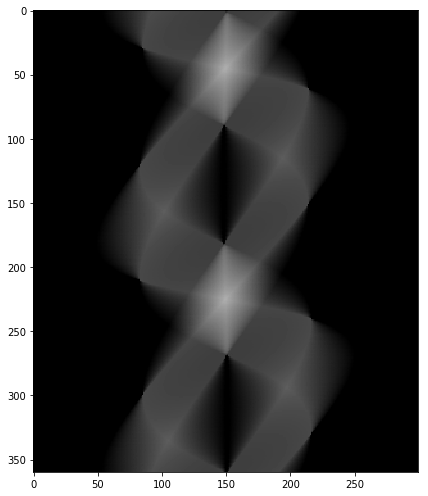

Retrieved image - Mean Squared Error:   0.293284208259


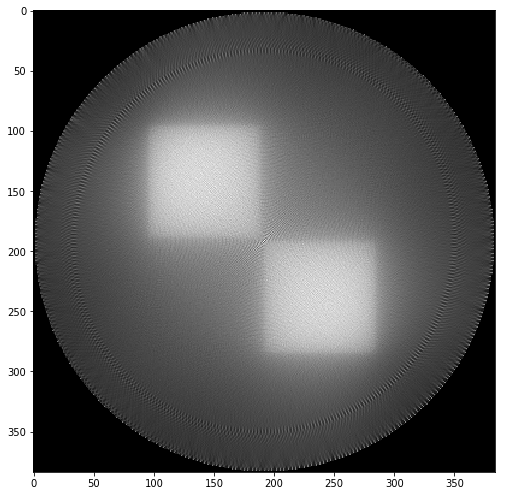

Sinogram:


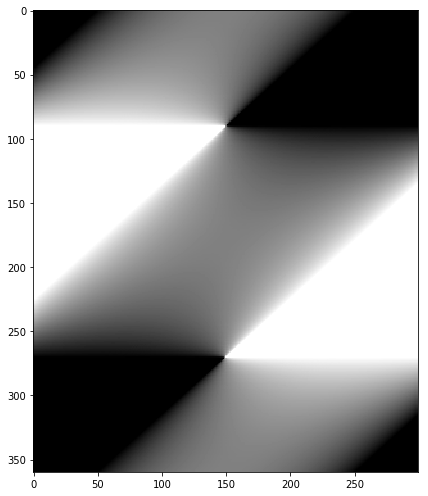

Retrieved image - Mean Squared Error:   0.46866177749


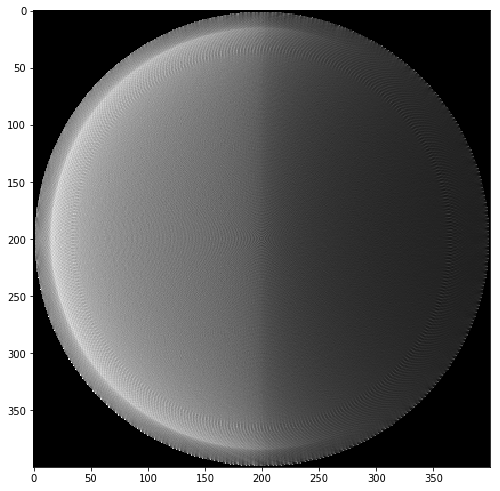

In [4]:
#GUI:
imageChooseButtons = widgets.ToggleButtons(
    options=os.listdir('tomograf-zdjecia'),
    description='Image:',
    disabled=False
)

sliderKrok = widgets.IntSlider(
    value=360,
    min=30,
    max=360,
    step=30,
    description='Krokow: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

sliderNdetektorow = widgets.IntSlider(
    value=300,
    min=30,
    max=360,
    step=30,
    description='Detektorow: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

sliderRozpietosc = widgets.IntSlider(
    value=270,
    min=30,
    max=330,
    step=30,
    description='Rozpietosc: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


checkFiltr = widgets.Checkbox(
    value=False,
    description='Filtr',
    disabled=False
)

executeButton = widgets.Button(description='Execute')

display(imageChooseButtons)
display(sliderKrok)
display(sliderNdetektorow)

display(sliderRozpietosc)
display(checkFiltr)
display(executeButton)

def myClick(b):
    main(sliderKrok.value, sliderNdetektorow.value, sliderRozpietosc.value, checkFiltr.value, imageChooseButtons.value)

executeButton.on_click(myClick)






In [8]:
from IPython.display import Image, display
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]
imgs = list(os.listdir('photos'))
imgs.sort(key = natural_keys)
def loadimg(k):
    display(Image(open(os.path.join('photos', imgs[k]),'rb').read()))
    print(imgs[k])
interact(loadimg ,k=(0, len(imgs) - 1))



interactive(children=(IntSlider(value=18, description='k', max=36), Output()), _dom_classes=('widget-interact',))

<function __main__.loadimg>